# Plot Predctions in Recovery Grid

In [1]:
import stella
import matplotlib.pyplot as plt
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import re

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
def get_max_around_time(file, target_time=1496.5, window_size=4):
    time = file[0]
    predictions = file[-1]

    closest_time_index = np.argmin(np.abs(time - target_time))
    
    left_bound = max(0, closest_time_index - window_size)
    right_bound = min(len(predictions), closest_time_index + window_size + 1)
    
    # Get the maximum within the window

    window_max = np.max(predictions[left_bound:right_bound])
    
    # # Get the corresponding time
    window_max_index = np.argmax(predictions[left_bound:right_bound]) + left_bound
    window_max_time = time[window_max_index]
    
    return window_max 



In [3]:
base_dir = '../exo9'

folders = [
    f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))
]

pattern = re.compile(
    r"injected-skew_(?P<skew>-?\d+(\.\d+)?)-duration-(?P<duration>\d+\.\d+)-snr-5"
)

skew_values = sorted(
    set(int(pattern.search(f).group("skew")) for f in folders if pattern.search(f))
)
duration_values = sorted(
    set(
        float(pattern.search(f).group("duration"))
        for f in folders
        if pattern.search(f)
    )
)

In [4]:
duration_values

[0.1, 0.14, 0.19, 0.27, 0.38, 0.53, 0.74, 1.03, 1.43, 2.0]

In [5]:
skew = 1
duration = 0.38
folder_pattern = f"injected-skew_{skew}-duration-{duration:.2f}-snr-5"

In [6]:
files = glob(f'../exo9/{folder_pattern}/*-predictions.npy')
np.random.shuffle(files)

IndexError: index 8 is out of bounds for axis 0 with size 8

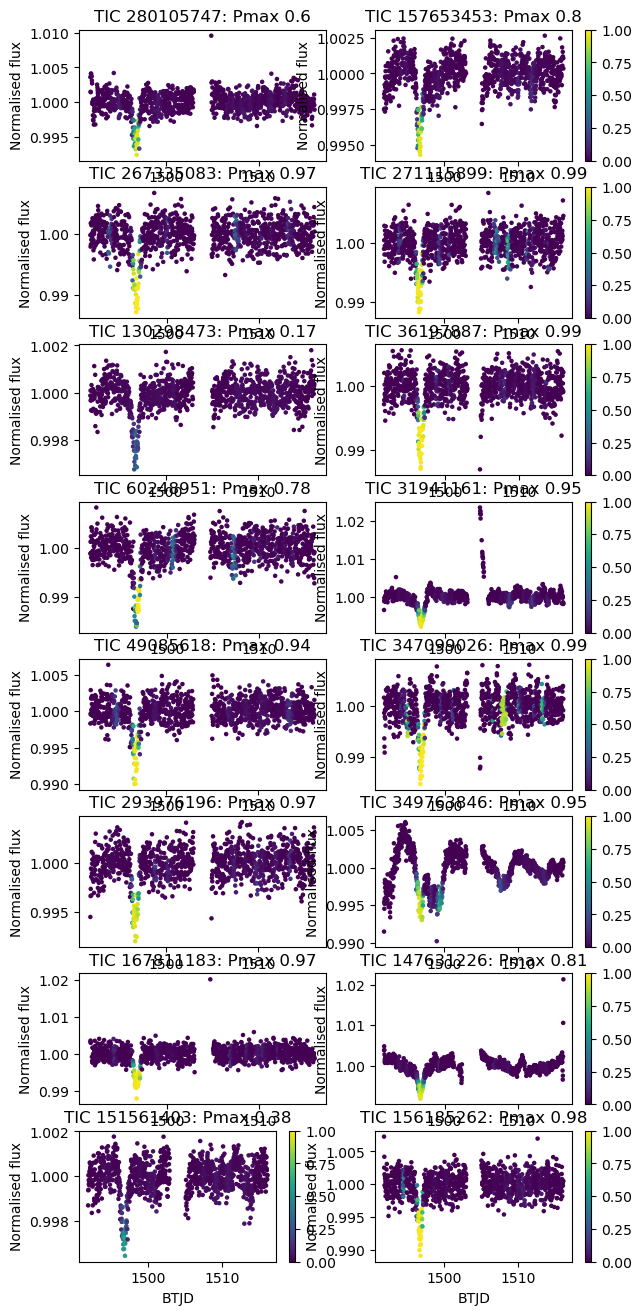

In [7]:
n_plots = 15 ## THIS HAS TO BE THE SAME AS THE ITERATIONS TO GO OVER
n_cols = 2
n_rows = (n_plots + 1) // 2  

# Create the main figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7,2 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)  

p = []
for i, file_path in enumerate(files):
    file = np.load(file_path, allow_pickle=True)
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    scatter = ax.scatter(file[0], file[1], c=file[-1], vmin=0, vmax=1, s=5)
    tic = file_path.split('_')[-2]
    pred = get_max_around_time(file)
    accpred = 1 if pred > 0.5 else 0 # [i for i in pred if i > 0.5] ## CHECK THIS I AM NOT SURE IF IT IS CORRECT

    #rec = sum(accpred)/len(pred)
    p.append(accpred)
    
    ax.set_title(f'TIC {tic}: Pmax {np.round(pred,2)}')
    ax.set_xlabel('BTJD')
    ax.set_ylabel('Normalised flux')
    
    if col == n_cols - 1 or i == n_plots - 1:
        plt.colorbar(scatter, ax=ax)

# Remove any unused subplots
for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()



In [ ]:
print("Recovery rate in this bin:", sum(p)/len(p))

## The main bulk of the code

In [34]:
skew_vals = np.arange(-15,15,1)
duration_vals = [1.43,2.0]

recovery = []
for duration in tqdm(duration_values):
    duration_recovery = []
    for j in skew_vals:
        pred = []
        folder_pattern = f"injected-skew_{j}-duration-{duration:.2f}-snr-5"
        files = glob(f'../exo9/{folder_pattern}/*-predictions.npy')
        np.random.shuffle(files)
        
        for file_path in files:
            file = np.load(file_path, allow_pickle=True)
            val_pred = get_max_around_time(file)
            accpred = 1 if val_pred > 0.5 else 0
            pred.append(accpred)

        rec = sum(pred)/len(pred)
        duration_recovery.append(rec)
    
    recovery.append(duration_recovery)

100%|█| 10


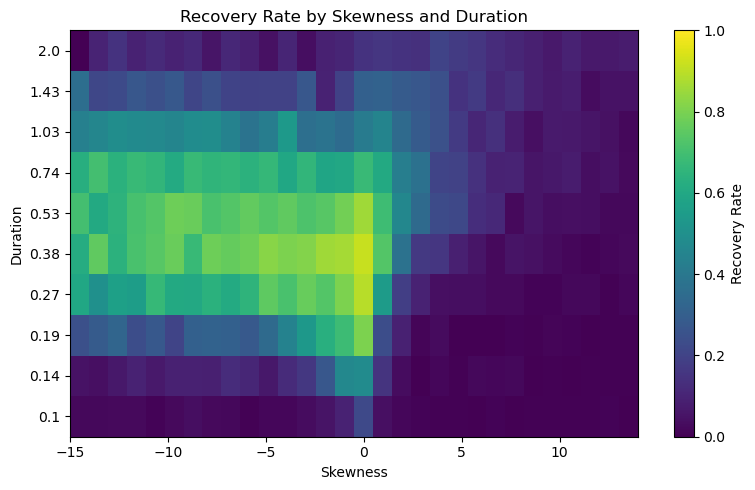

In [35]:
recovery = np.array(recovery)

fig, ax = plt.subplots(figsize=(8,5))

# Use imshow to create the 2D plot
im = ax.imshow(recovery, aspect='auto', origin='lower', 
               extent=[skew_vals[0], skew_vals[-1], -0.5, len(duration_values)-0.5],
               vmin=0, vmax=1)

# Set y-ticks at the center of each cell
ax.set_yticks(np.arange(len(duration_values)))
ax.set_yticklabels(duration_values)

# Set x-ticks at the center of each cell


# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Recovery Rate')

# Set labels and title
ax.set_xlabel('Skewness')
ax.set_ylabel('Duration')
ax.set_title('Recovery Rate by Skewness and Duration')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

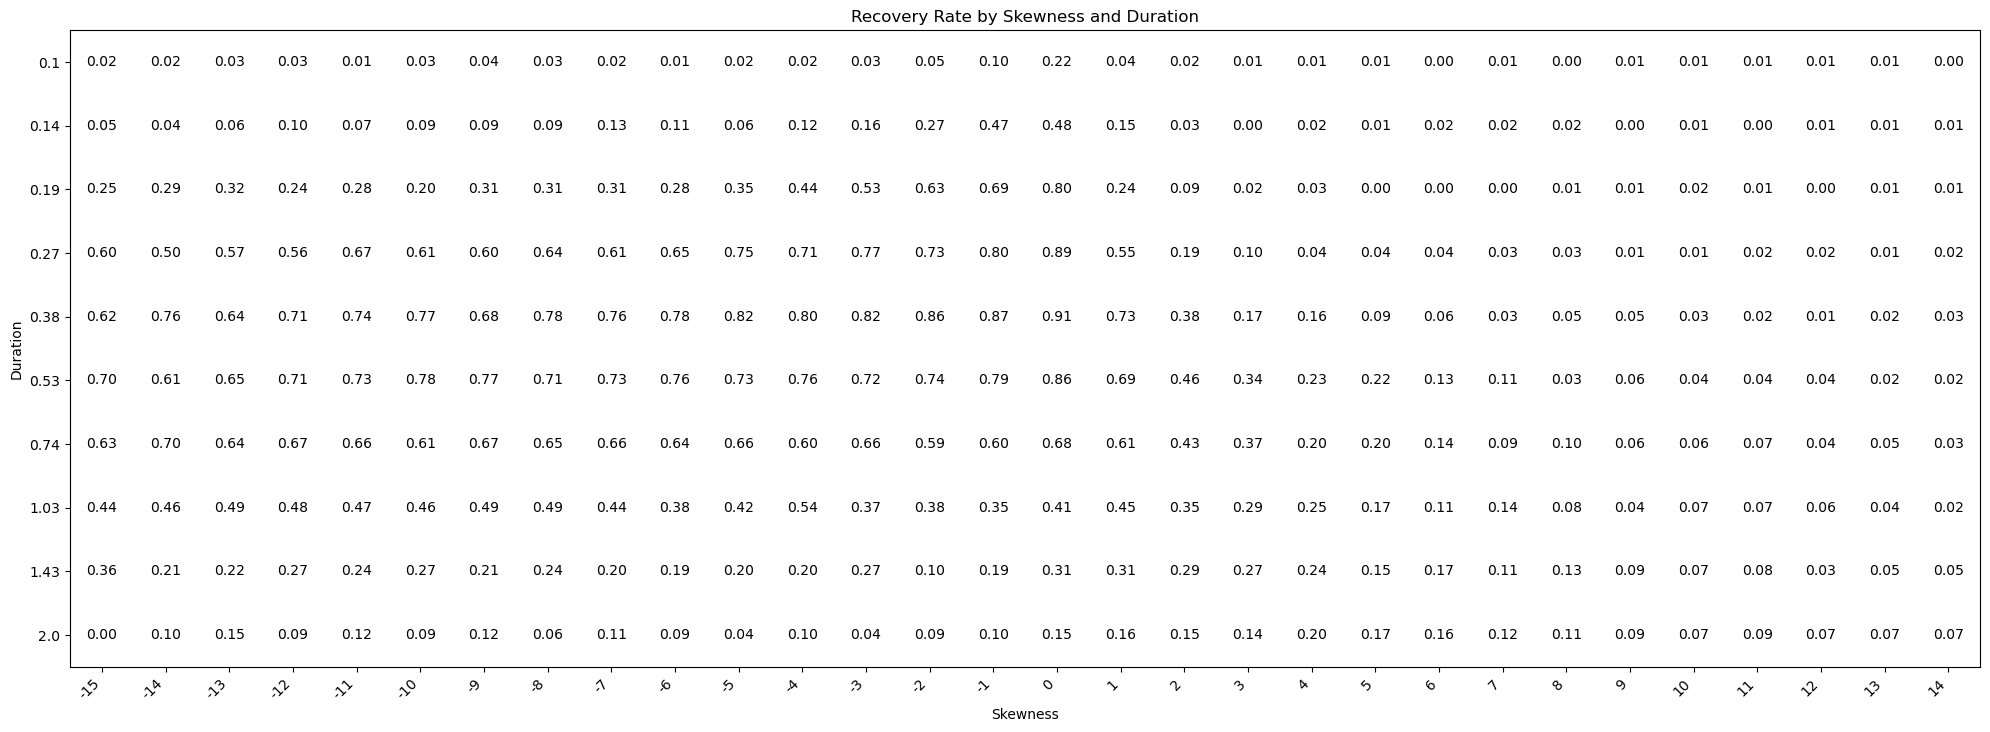

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))  # Adjust figure size as needed

# Create a blank white canvas
ax.imshow(np.ones_like(recovery), cmap='Greys', alpha=0)

# Add text annotations for each cell
for i in range(recovery.shape[0]):
    for j in range(recovery.shape[1]):
        text = ax.text(j, i, f'{recovery[i, j]:.2f}', 
                       ha='center', va='center', color='black')

# Set ticks and labels
ax.set_xticks(np.arange(len(skew_vals)))
ax.set_yticks(np.arange(len(duration_values)))
ax.set_xticklabels(skew_vals)
ax.set_yticklabels(duration_values)

# Set labels and title
ax.set_xlabel('Skewness')
ax.set_ylabel('Duration')
ax.set_title('Recovery Rate by Skewness and Duration')

# Rotate x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


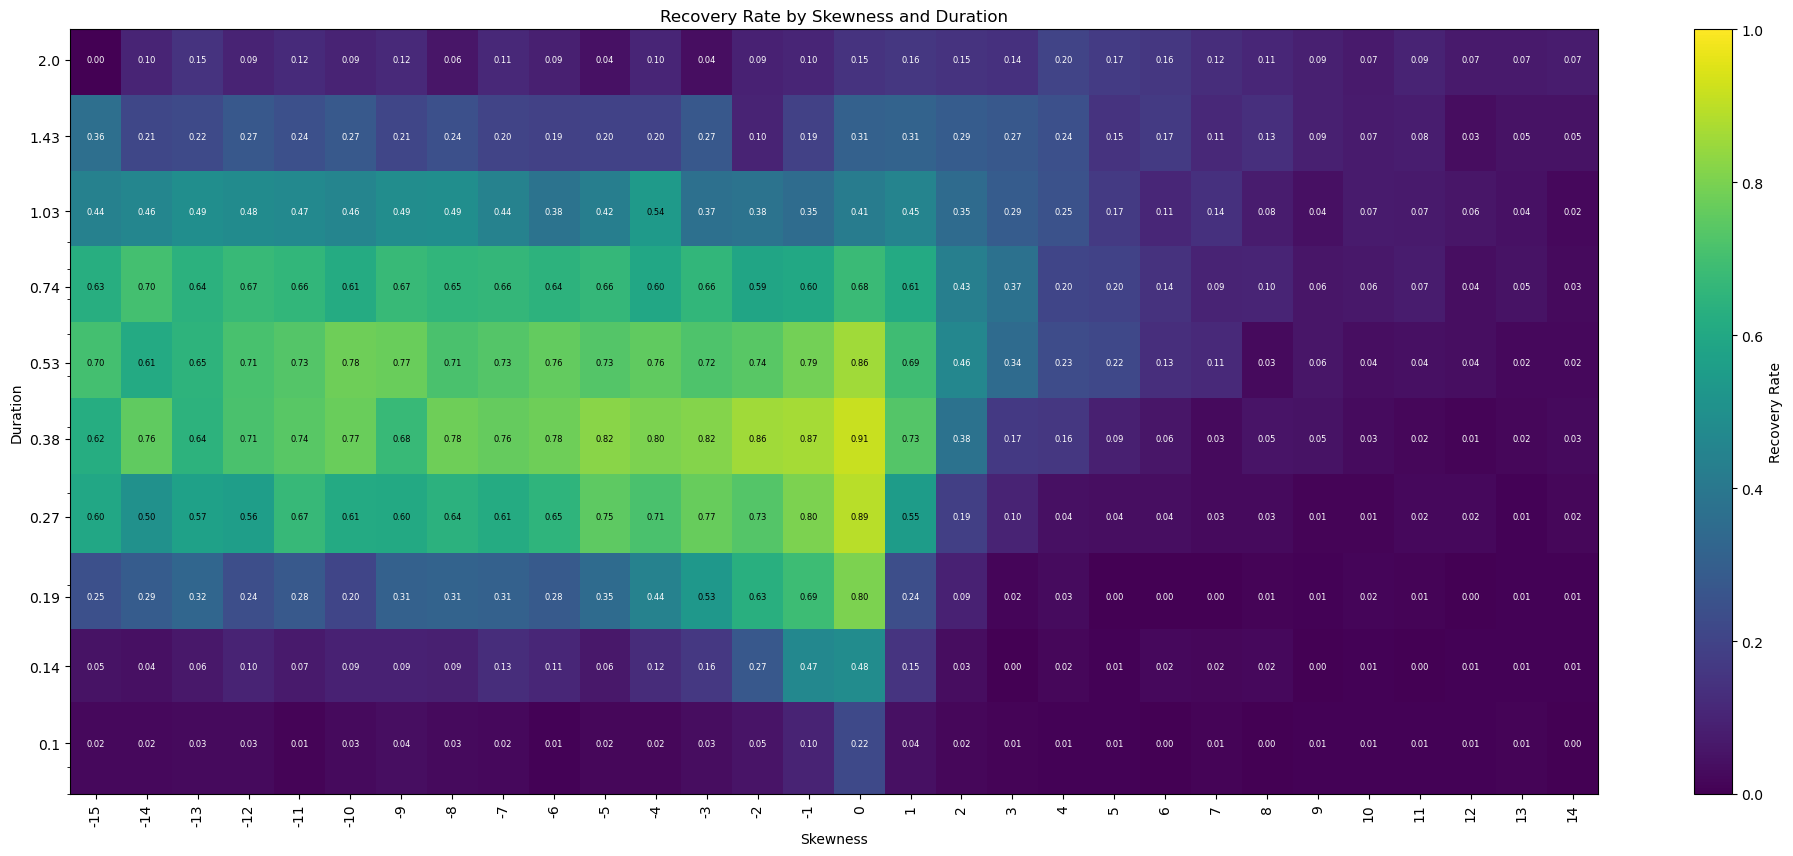

In [76]:
fig, ax = plt.subplots(figsize=(20, 10))

# Create mesh for pcolormesh
X, Y = np.meshgrid(skew_vals, duration_values)

# Create the color plot
pcm = ax.pcolormesh(X, Y, recovery, shading='auto', vmin=0, vmax=1, cmap='viridis')

# Add text annotations for each cell
for i in range(recovery.shape[0]):
    for j in range(recovery.shape[1]):
        text_color = 'white' if recovery[i, j] < 0.5 else 'black'
        ax.text(skew_vals[j], duration_values[i], f'{recovery[i, j]:.2f}', 
                ha='center', va='center', color=text_color, fontsize=6)

# Set ticks and labels
ax.set_xticks(skew_vals)
ax.set_xticklabels(skew_vals)

# Add colorbar
cbar = plt.colorbar(pcm)
cbar.set_label('Recovery Rate')


# Set labels and title
ax.set_xlabel('Skewness')
ax.set_ylabel('Duration')
ax.set_title('Recovery Rate by Skewness and Duration')

# Rotate and align the tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
plt.setp(ax.get_yticklabels(), ha='right')

# Use a tight layout, but adjust for the rotated x-axis labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
ax.set_yscale('log')

ax.set_yticks(duration_values)
ax.set_yticklabels(duration_values)
# Show the plot
plt.show()

---

## Let's try the grid for one column

In [5]:
import stella
from itertools import product

In [6]:
def process_file(
    file,
    cnn,
    modelname="/Users/azib/Documents/open_source/nets2/cnn-models/ensemble_s0002_i0200_b0.7.h5",
):
    try:
        time, flux, errs, _ = np.load(file, allow_pickle=True)
        cnn.predict(modelname=modelname, times=time, fluxes=flux, errs=errs)
        ### create function to save arrays
        time = cnn.predict_time[0]
        flux = cnn.predict_flux[0]
        errs = cnn.predict_err[0]
        predictions = cnn.predictions[0]

        path_no_extenstion = os.path.splitext(file)[0]
        newfile = path_no_extenstion + "-predictions.npy"

        np.save(newfile,np.array([time,flux,errs,predictions]))


        closest_index = np.argmin(np.abs(np.array(cnn.predict_time) - 1496.5))

        ## time boundary conditions
        start_index = max(closest_index - 4, 0)
        end_index = min(closest_index + 5, len(cnn.predictions[0]))

        return 1 if np.max(cnn.predictions[0][start_index:end_index]) > 0.5 else 0
    except Exception as e:
        return 0


def process_folder(args):
    base_dir, skew, duration, cnn = args
    folder_pattern = f"injected-skew_{skew}-duration-{duration:.2f}-snr-5"
    files = glob(os.path.join(base_dir, folder_pattern, "*sector07.npy"))[0:10]

    if not files:
        return 0

    labels = [process_file(file, cnn) for file in files]
    return sum(labels) / len(labels) if labels else 0

### Read in Datasets to get `cnn`

In [7]:
exoplanets = stella.FlareDataSet(
    fn_dir="/Users/azib/Documents/open_source/nets2/models/exoplanets1k/",
    catalog="/Users/azib/Documents/open_source/nets2/catalogs/exoplanets1k.txt",
    cadences=168,
    training=0.8,
    validation=0.1,
    frac_balance=1,
)
fbinaries = stella.FlareDataSet(
    fn_dir="/Users/azib/Documents/open_source/nets2/models/binaries1k/",
    catalog="/Users/azib/Documents/open_source/nets2/catalogs/fakebinaries1k.txt",
    cadences=168,
    training=0.8,
    validation=0.1,
    frac_balance=1,
)
rbinaries = stella.FlareDataSet(
    fn_dir="/Users/azib/Documents/open_source/nets2/models/binaries-s7/",
    catalog="/Users/azib/Documents/open_source/nets2/catalogs/binaries-catalog-s7.txt",
    cadences=168,
    training=0.65,
    validation=0.1,
    frac_balance=1,
)
ds = stella.FlareDataSet(
    fn_dir="/Users/azib/Documents/open_source/nets2/models/comets5k/",
    catalog="/Users/azib/Documents/open_source/nets2/catalogs/comets.txt",
    cadences=168,
    training=0.8,
    validation=0.1,
    merge_datasets=True,
    frac_balance=0.7,
    other_datasets=[exoplanets, fbinaries, rbinaries],
    other_datasets_labels=[2, 3, 4],
    augment_portion=0.4
)

cnn = stella.ConvNN(
    output_dir="/Users/azib/Documents/open_source/nets2/cnn-models/", ds=ds
)

Reading in training set files.


100%|█|


Number of positive class training data: 799
Number of negative class training data: 0
Number of positive class validation data: 100
Number of negative class validation data: 0
Size of augmented data (training set only): 0
Class label (training): 1, Count: 799
Class label (validation): 1, Count: 100
Total size of training set: 799
Total size of validation set: 100
Total size of test set: 100
No second class to calculate imbalance.
Reading in training set files.


100%|█|


Number of positive class training data: 800
Number of negative class training data: 0
Number of positive class validation data: 100
Number of negative class validation data: 0
Size of augmented data (training set only): 0
Class label (training): 1, Count: 800
Class label (validation): 1, Count: 100
Total size of training set: 800
Total size of validation set: 100
Total size of test set: 100
No second class to calculate imbalance.
Reading in training set files.


100%|█|


Number of positive class training data: 1690
Number of negative class training data: 0
Number of positive class validation data: 260
Number of negative class validation data: 0
Size of augmented data (training set only): 0
Class label (training): 1, Count: 1690
Class label (validation): 1, Count: 260
Total size of training set: 1690
Total size of validation set: 260
Total size of test set: 650
No second class to calculate imbalance.
Reading in training set files.


100%|█|


Number of positive class training data: 4010
Number of negative class training data: 9076
Number of positive class validation data: 501
Number of negative class validation data: 934
Size of augmented data (training set only): 1604
Class label (training): 0, Count: 7472
Class label (training): 1, Count: 4010
Class label (training): 99, Count: 1604
Class label (validation): 0, Count: 482
Class label (validation): 1, Count: 501
Class label (validation): 2, Count: 83
Class label (validation): 3, Count: 97
Class label (validation): 4, Count: 272
Total size of training set: 13086
Total size of validation set: 1435
Total size of test set: 1436
Approximate class imbalance: 56.0


## Run

In [8]:
base_dir = '../exo9'

folders = [
    f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))
]

pattern = re.compile(
    r"injected-skew_(?P<skew>-?\d+(\.\d+)?)-duration-(?P<duration>\d+\.\d+)-snr-5"
)

skew_values = sorted(
    set(int(pattern.search(f).group("skew")) for f in folders if pattern.search(f))
)
duration_values = sorted(
    set(
        float(pattern.search(f).group("duration"))
        for f in folders
        if pattern.search(f)
    )
)

args_list = [
    (base_dir, skew, duration, cnn)
    for skew, duration in product(skew_values, duration_values)
]

In [29]:
result = []
for i in range(0, len(args_list), 10):
    batch = args_list[i:i+10]
    rec = []
    for item in batch:
        percent = process_folder(item)
        rec.append(percent)
    result.append(np.array(rec))

stacked_result = np.vstack(result)
final_result = stacked_result.T[::-1]

100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
  0%| |
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
  0%| |
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
  0%| |
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
  0%| |
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|
100%|█|


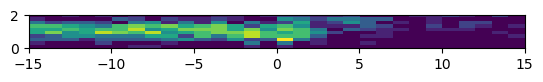

In [33]:
plt.imshow(final_result,extent=[-15,15,0,2])

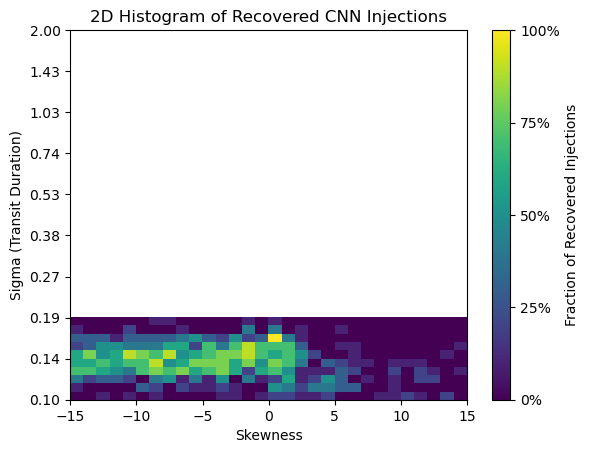

In [40]:
plt.imshow(
    final_result,
    extent=[-15,15,0,2],
    aspect="auto",
    origin="lower",
    cmap="viridis",
    vmin=0,
    vmax=1,
)
cbar = plt.colorbar(label="Fraction of Recovered Injections")
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(["0%", "25%", "50%", "75%", "100%"])
plt.xlabel("Skewness")
plt.ylabel("Sigma (Transit Duration)")
plt.title("2D Histogram of Recovered CNN Injections")

# Adjust y-axis ticks to show actual duration values
plt.yticks(
    np.arange(len(duration_values)) + 0.5, [f"{d:.2f}" for d in duration_values]
)

plt.savefig("recovery-plot-time-and-ind-cond-all-wider-window.png", dpi=200)
plt.show()
plt.close()

In [37]:
np.array(final_result).reshape(10, 30)

array([[0. , 0. , 0.1, 0. , 0.1, 0. , 0.1, 0. , 0. , 0. , 0. , 0.1, 0.1,
        0. , 0.1, 0.2, 0.2, 0.1, 0.1, 0.2, 0. , 0. , 0. , 0.1, 0.1, 0.2,
        0.1, 0. , 0.2, 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0.3, 0.2, 0. , 0.2, 0.1, 0.1, 0.2, 0.1,
        0. , 0. , 0.5, 0.4, 0.2, 0.4, 0.4, 0.3, 0.3, 0. , 0. , 0.1, 0. ,
        0. , 0. , 0. , 0. ],
       [0.4, 0.2, 0.3, 0.3, 0.2, 0. , 0.4, 0.5, 0.1, 0.4, 0.1, 0.5, 0. ,
        0.4, 0.1, 0.2, 0.6, 0.1, 0.2, 0.5, 0.3, 0. , 0.1, 0. , 0.1, 0. ,
        0.2, 0.2, 0. , 0. ],
       [0.7, 0.7, 0.6, 0.5, 0.4, 0.7, 0.8, 0.7, 0.8, 0.6, 0.7, 0.8, 0.6,
        0.2, 0.6, 0.7, 0.5, 0.1, 0.1, 0.1, 0.3, 0.2, 0. , 0. , 0.2, 0. ,
        0.2, 0.1, 0. , 0.1],
       [0.6, 0.6, 0.7, 0.6, 0.7, 0.7, 0.9, 0.5, 0.6, 0.8, 0.8, 0.8, 0.6,
        0.8, 0.5, 0.8, 0.7, 0.4, 0. , 0.3, 0.2, 0.1, 0.1, 0. , 0.1, 0.1,
        0.1, 0. , 0. , 0. ],
       [0.6, 0.8, 0.5, 0.6, 0.9, 0.8, 0.7, 0.9, 0.5, 0.6, 0.7, 0.8, 0.8,
        0.9, 0.7, 0.6, 0.7, 0.5, 0.2, 0. , 0. , 0.1,

In [41]:
final_result

array([[0. , 0. , 0.1, 0. , 0.1, 0. , 0.1, 0. , 0. , 0. , 0. , 0.1, 0.1,
        0. , 0.1, 0.2, 0.2, 0.1, 0.1, 0.2, 0. , 0. , 0. , 0.1, 0.1, 0.2,
        0.1, 0. , 0.2, 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0.3, 0.2, 0. , 0.2, 0.1, 0.1, 0.2, 0.1,
        0. , 0. , 0.5, 0.4, 0.2, 0.4, 0.4, 0.3, 0.3, 0. , 0. , 0.1, 0. ,
        0. , 0. , 0. , 0. ],
       [0.4, 0.2, 0.3, 0.3, 0.2, 0. , 0.4, 0.5, 0.1, 0.4, 0.1, 0.5, 0. ,
        0.4, 0.1, 0.2, 0.6, 0.1, 0.2, 0.5, 0.3, 0. , 0.1, 0. , 0.1, 0. ,
        0.2, 0.2, 0. , 0. ],
       [0.7, 0.7, 0.6, 0.5, 0.4, 0.7, 0.8, 0.7, 0.8, 0.6, 0.7, 0.8, 0.6,
        0.2, 0.6, 0.7, 0.5, 0.1, 0.1, 0.1, 0.3, 0.2, 0. , 0. , 0.2, 0. ,
        0.2, 0.1, 0. , 0.1],
       [0.6, 0.6, 0.7, 0.6, 0.7, 0.7, 0.9, 0.5, 0.6, 0.8, 0.8, 0.8, 0.6,
        0.8, 0.5, 0.8, 0.7, 0.4, 0. , 0.3, 0.2, 0.1, 0.1, 0. , 0.1, 0.1,
        0.1, 0. , 0. , 0. ],
       [0.6, 0.8, 0.5, 0.6, 0.9, 0.8, 0.7, 0.9, 0.5, 0.6, 0.7, 0.8, 0.8,
        0.9, 0.7, 0.6, 0.7, 0.5, 0.2, 0. , 0. , 0.1,

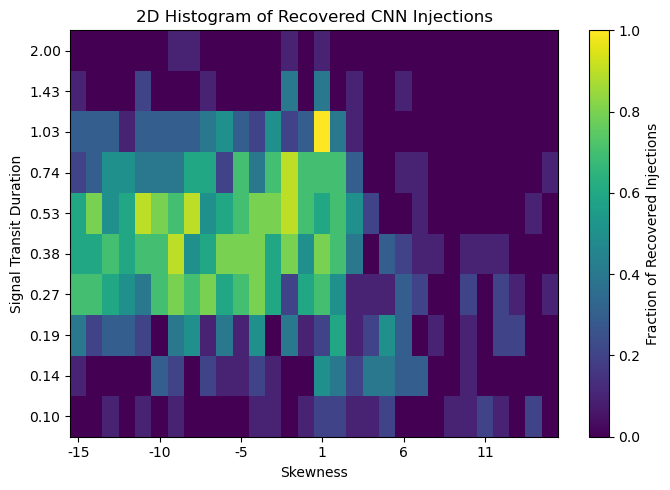

In [44]:
plt.figure(figsize=(7,5))
plt.imshow(final_result, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label='Fraction of Recovered Injections')

# Set labels and title
plt.xlabel('Skewness')
plt.ylabel('Signal Transit Duration')
plt.title('2D Histogram of Recovered CNN Injections')

# Adjust y-axis ticks to show actual duration values
duration_values = [0.10, 0.14, 0.19, 0.27, 0.38, 0.53, 0.74, 1.03, 1.43, 2.00]
plt.yticks(range(len(duration_values)), [f'{d:.2f}' for d in duration_values])

# Adjust x-axis ticks
skewness_values = np.linspace(-15, 15, 30)
plt.xticks(np.arange(0, 30, 5), [f'{s:.0f}' for s in skewness_values[::5]])

plt.tight_layout()
plt.show()

In [52]:
final_result > 0.85

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False,